In [1]:
from sklearn.decomposition import PCA
from pennylane import numpy as np
import pennylane as qml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import combinations
from scipy import stats as st
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Function Definitions and Quantum Device Setup

In [2]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

In [3]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)

In [4]:
def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    np.random.seed(5687)
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

In [5]:
dev = qml.device("default.qubit", wires=3, shots=None)
wires = dev.wires.tolist()

In [6]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

In [7]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

In [8]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [9]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [10]:
def train(params, X_train, y_train, steps, subset_size, lr,alignment_target=None, idx=None):
    opt = qml.GradientDescentOptimizer(lr)

    for i in range(steps):
        # Choose subset of datapoints to compute the KTA on.
        if idx:
            subset = idx
        else:
            subset = np.random.choice(list(range(len(X_train))), subset_size)
        # Define the cost function for optimization
        cost = lambda _params: -target_alignment(
          X_train[subset],
          y_train[subset],
          lambda x1, x2: kernel(x1, x2, _params),
          assume_normalized_kernel=True,
        )
        # Optimization step
        params = opt.step(cost, params)

        # Report the alignment on the full dataset every 50 steps.
        if (i + 1) % 50 == 0:
            current_alignment = target_alignment(
              X_train,
              y_train,
              lambda x1, x2: kernel(x1, x2, params),
              assume_normalized_kernel=True,
            )
            print(f"Step {i+1} - Alignment = {current_alignment:.3f}")
            if alignment_target and (current_alignment >= alignment_target):
                break
    return params

# IRIS L=1

In [12]:
from sklearn.datasets import load_iris
data = load_iris()

In [13]:
Y = np.copy(data['target'])
X = data['data']
pca = PCA(n_components=2)
X = pca.fit_transform(X)
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)*np.pi

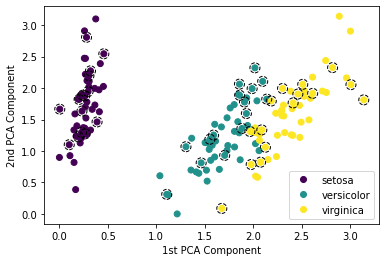

In [18]:
pl = plt.scatter(X_minmax[:,0], X_minmax[:,1], c=Y)
plt.xlabel('1st PCA Component')
plt.ylabel('2nd PCA Component')
plt.legend(handles=pl.legend_elements()[0], labels=list(data['target_names']))

In [30]:
quantum_accuracies_trained = []
quantum_accuracies_untrained = []
for rdm in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_minmax,Y, test_size=0.3, stratify=Y, random_state=rdm)
    pred_all_trained = []
    pred_all_untrained = []
    all_params = {}
    init_params = random_params(num_wires=3, num_layers=1)
    init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
    for y1, y2 in combinations(np.unique(Y).numpy(), r=2):
        mask = (y_train==y1) | (y_train==y2)
        y_train_pair = y_train[mask]
        X_train_pair = X_train[mask]
        y_train_pair [y_train_pair == y1] = -1
        y_train_pair [y_train_pair == y2] = 1
        svm_untrained = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train_pair, y_train_pair)
        test_mask = (y_test==y1) | (y_test==y2)
        y_test_pair = y_test[test_mask]
        X_test_pair = X_test[test_mask]
        y_test_pair [y_test_pair == y1] = -1
        y_test_pair [y_test_pair == y2] = 1
        y_pred_pair = svm_untrained.predict(X_test_pair)
        test_accuracy = 1 - np.count_nonzero(y_pred_pair - y_test_pair) / len(y_test_pair)
        print(f"Test Accuracy:{test_accuracy*100:.2f}")
        lr = 2
        new_test_accuracy = test_accuracy
        while (new_test_accuracy != 1) and (new_test_accuracy <= test_accuracy) and (lr >= 0.5):
            if lr >=1 :
                iterations= 500
            else:
                iterations= 1000
            params = all_params.get((y1, y2), init_params)
            params = train(params, X_train_pair, y_train_pair, iterations, 4, lr)
            all_params[(y1, y2)] = params
            trained_kernel = lambda x1, x2: kernel(x1, x2, params)
            svm_trained = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)).fit(X_train_pair, y_train_pair)
            y_pred_pair_new = svm_trained.predict(X_test_pair)
            new_test_accuracy = 1 - np.count_nonzero(y_pred_pair_new - y_test_pair) / len(y_test_pair)
            print(f"Test Accuracy:{new_test_accuracy*100:.2f}")
            lr /= 2
        untrained_predictions = svm_untrained.predict(X_test)
        pred_all_untrained.append((untrained_predictions, (y1,y2)))
        if new_test_accuracy <= test_accuracy:
            pred_all_trained.append((untrained_predictions, (y1,y2)))
        else:
            pred_all_trained.append((svm_trained.predict(X_test), (y1,y2)))
    y_pred_all = []
    for y_pred_pair, labels in pred_all_untrained:
        y_pred_pair[y_pred_pair==-1]=0
        labels = np.array(labels).numpy()
        y_pred_all.append(labels[y_pred_pair])
    y_pred = st.mode(np.vstack(y_pred_all).numpy(),axis=0)[0]
    final_accuracy_untrained = 1 - np.count_nonzero(y_pred - y_test) / len(y_test)
    quantum_accuracies_untrained.append(final_accuracy_untrained*100)
    print(f"Final Accuracy Untrained {final_accuracy_untrained*100:.2f}")
    y_pred_all = []
    for y_pred_pair, labels in pred_all_trained:
        y_pred_pair[y_pred_pair==-1]=0
        labels = np.array(labels).numpy()
        y_pred_all.append(labels[y_pred_pair])
    y_pred = st.mode(np.vstack(y_pred_all).numpy(),axis=0)[0]
    final_accuracy_trained = 1 - np.count_nonzero(y_pred - y_test) / len(y_test)
    quantum_accuracies_trained.append(final_accuracy_trained*100)
    print(f"Final Accuracy Trained {final_accuracy_trained*100:.2f}")


Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Final Accuracy Untrained 100.00
Final Accuracy Trained 100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:93.33
Step 50 - Alignment = 0.126
Step 100 - Alignment = 0.126
Step 150 - Alignment = 0.126
Step 200 - Alignment = 0.126
Step 250 - Alignment = 0.126
Step 300 - Alignment = 0.126
Step 350 - Alignment = 0.126
Step 400 - Alignment = 0.126
Step 450 - Alignment = 0.126
Step 500 - Alignment = 0.126
Test Accuracy:93.33
Step 50 - Alignment = 0.126
Step 100 - Alignment = 0.126
Step 150 - Alignment = 0.126
Step 200 - Alignment = 0.126
Step 250 - Alignment = 0.126
Step 300 - Alignment = 0.126
Step 350 - Alignment = 0.126
Step 400 - Alignment = 0.126
Step 450 - Alignment = 0.126
Step 500 - Alignment = 0.126
Test Accuracy:93.33
Step 50 - Alignment = 0.126
Step 100 - Alignment = 0.126
Step 150 - Alignment = 0.126
Step 200 - Alignment = 0.126
Step 250 - Alignment = 0.126
Step 300 - Alignment = 0.126
Step 350 - Alignment =

In [35]:
np.array(quantum_accuracies_trained) >= np.array(quantum_accuracies_untrained)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True], requires_grad=True)

In [31]:
np.mean(quantum_accuracies_untrained)

94.88888888888889

In [32]:
np.std(quantum_accuracies_untrained)

2.819683897877672

In [33]:
np.mean(quantum_accuracies_trained)

94.88888888888889

In [34]:
np.std(quantum_accuracies_trained)

2.819683897877672

In [29]:
classical_accuracies = []
for ker in ['rbf', 'linear', 'poly']:
  acc = []
  for rdm in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_minmax,Y, test_size=0.3, stratify=Y, random_state=rdm)
    clf = SVC(kernel=ker)
    clf.fit(X_train, y_train)
    acc.append(accuracy(clf, X_test, y_test)*100)
  print(f"Kernel: {ker}\t Mean: {np.mean(acc):.2f} \t Std: {np.std(acc):.2f}")

Kernel: rbf	 Mean: 94.67 	 Std: 2.67
Kernel: linear	 Mean: 94.67 	 Std: 2.47
Kernel: poly	 Mean: 95.11 	 Std: 2.59


# MNIST L=1

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()

In [12]:
X = digits['data']
Y = digits['target']

idx = np.hstack([np.where(Y==i)[0][:20] for i in np.unique(Y)])
X = X[idx]
Y = Y[idx]

pca = PCA(n_components=2)
X = pca.fit_transform(X)
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)*np.pi

In [13]:
classical_accuracies = []
for ker in ['rbf', 'linear', 'poly']:
  acc = []
  for rdm in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_minmax,Y, test_size=0.3, stratify=Y, random_state=rdm)
    clf = SVC(kernel=ker)
    clf.fit(X_train, y_train)
    acc.append(accuracy(clf, X_test, y_test)*100)
  print(f"Kernel: {ker}\t Mean: {np.mean(acc):.2f} \t Std: {np.std(acc):.2f}")

Kernel: rbf	 Mean: 75.33 	 Std: 4.93
Kernel: linear	 Mean: 72.17 	 Std: 4.72
Kernel: poly	 Mean: 72.17 	 Std: 6.01


In [14]:
quantum_accuracies_trained = []
quantum_accuracies_untrained = []
for rdm in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_minmax,Y, test_size=0.3, stratify=Y, random_state=rdm)
    pred_all_trained = []
    pred_all_untrained = []
    all_params = {}
    init_params = random_params(num_wires=3, num_layers=1)
    init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
    for y1, y2 in combinations(np.unique(Y).numpy(), r=2):
        mask = (y_train==y1) | (y_train==y2)
        y_train_pair = y_train[mask]
        X_train_pair = X_train[mask]
        y_train_pair [y_train_pair == y1] = -1
        y_train_pair [y_train_pair == y2] = 1
        svm_untrained = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train_pair, y_train_pair)
        test_mask = (y_test==y1) | (y_test==y2)
        y_test_pair = y_test[test_mask]
        X_test_pair = X_test[test_mask]
        y_test_pair [y_test_pair == y1] = -1
        y_test_pair [y_test_pair == y2] = 1
        y_pred_pair = svm_untrained.predict(X_test_pair)
        test_accuracy = 1 - np.count_nonzero(y_pred_pair - y_test_pair) / len(y_test_pair)
        print(f"Test Accuracy:{test_accuracy*100:.2f}")
        lr = 2
        new_test_accuracy = test_accuracy
        while (new_test_accuracy != 1) and (new_test_accuracy <= test_accuracy) and (lr >= 0.5):
            if lr >=1 :
                iterations= 500
            else:
                iterations= 1000
            params = all_params.get((y1, y2), init_params)
            params = train(params, X_train_pair, y_train_pair, iterations, 4, lr)
            all_params[(y1, y2)] = params
            trained_kernel = lambda x1, x2: kernel(x1, x2, params)
            svm_trained = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)).fit(X_train_pair, y_train_pair)
            y_pred_pair_new = svm_trained.predict(X_test_pair)
            new_test_accuracy = 1 - np.count_nonzero(y_pred_pair_new - y_test_pair) / len(y_test_pair)
            print(f"Test Accuracy:{new_test_accuracy*100:.2f}")
            lr /= 2
        untrained_predictions = svm_untrained.predict(X_test)
        pred_all_untrained.append((untrained_predictions, (y1,y2)))
        if new_test_accuracy <= test_accuracy:
            pred_all_trained.append((untrained_predictions, (y1,y2)))
        else:
            pred_all_trained.append((svm_trained.predict(X_test), (y1,y2)))
    y_pred_all = []
    for y_pred_pair, labels in pred_all_untrained:
        y_pred_pair[y_pred_pair==-1]=0
        labels = np.array(labels).numpy()
        y_pred_all.append(labels[y_pred_pair])
    y_pred = st.mode(np.vstack(y_pred_all).numpy(),axis=0)[0]
    final_accuracy_untrained = 1 - np.count_nonzero(y_pred - y_test) / len(y_test)
    quantum_accuracies_untrained.append(final_accuracy_untrained*100)
    print(f"Final Accuracy Untrained {final_accuracy_untrained*100:.2f}")
    y_pred_all = []
    for y_pred_pair, labels in pred_all_trained:
        y_pred_pair[y_pred_pair==-1]=0
        labels = np.array(labels).numpy()
        y_pred_all.append(labels[y_pred_pair])
    y_pred = st.mode(np.vstack(y_pred_all).numpy(),axis=0)[0]
    final_accuracy_trained = 1 - np.count_nonzero(y_pred - y_test) / len(y_test)
    quantum_accuracies_trained.append(final_accuracy_trained*100)
    print(f"Final Accuracy Trained {final_accuracy_trained*100:.2f}")

Test Accuracy:100.00
Test Accuracy:66.67
Step 50 - Alignment = 0.096
Step 100 - Alignment = 0.096
Step 150 - Alignment = 0.096
Step 200 - Alignment = 0.096
Step 250 - Alignment = 0.096
Step 300 - Alignment = 0.096
Step 350 - Alignment = 0.096
Step 400 - Alignment = 0.096
Step 450 - Alignment = 0.096
Step 500 - Alignment = 0.096
Test Accuracy:66.67
Step 50 - Alignment = 0.096
Step 100 - Alignment = 0.096
Step 150 - Alignment = 0.096
Step 200 - Alignment = 0.096
Step 250 - Alignment = 0.096
Step 300 - Alignment = 0.096
Step 350 - Alignment = 0.096
Step 400 - Alignment = 0.096
Step 450 - Alignment = 0.096
Step 500 - Alignment = 0.096
Test Accuracy:66.67
Step 50 - Alignment = 0.096
Step 100 - Alignment = 0.096
Step 150 - Alignment = 0.096
Step 200 - Alignment = 0.096
Step 250 - Alignment = 0.096
Step 300 - Alignment = 0.096
Step 350 - Alignment = 0.096
Step 400 - Alignment = 0.096
Step 450 - Alignment = 0.096
Step 500 - Alignment = 0.096
Step 550 - Alignment = 0.096
Step 600 - Alignment = 

Step 250 - Alignment = 0.015
Step 300 - Alignment = 0.015
Step 350 - Alignment = 0.015
Step 400 - Alignment = 0.015
Step 450 - Alignment = 0.015
Step 500 - Alignment = 0.015
Test Accuracy:75.00
Step 50 - Alignment = 0.015
Step 100 - Alignment = 0.015
Step 150 - Alignment = 0.015
Step 200 - Alignment = 0.015
Step 250 - Alignment = 0.015
Step 300 - Alignment = 0.015
Step 350 - Alignment = 0.015
Step 400 - Alignment = 0.015
Step 450 - Alignment = 0.015
Step 500 - Alignment = 0.015
Step 550 - Alignment = 0.015
Step 600 - Alignment = 0.015
Step 650 - Alignment = 0.015
Step 700 - Alignment = 0.015
Step 750 - Alignment = 0.015
Step 800 - Alignment = 0.015
Step 850 - Alignment = 0.015
Step 900 - Alignment = 0.015
Step 950 - Alignment = 0.015
Step 1000 - Alignment = 0.015
Test Accuracy:75.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100

Step 350 - Alignment = 0.121
Step 400 - Alignment = 0.121
Step 450 - Alignment = 0.121
Step 500 - Alignment = 0.121
Test Accuracy:91.67
Step 50 - Alignment = 0.121
Step 100 - Alignment = 0.121
Step 150 - Alignment = 0.121
Step 200 - Alignment = 0.121
Step 250 - Alignment = 0.121
Step 300 - Alignment = 0.121
Step 350 - Alignment = 0.121
Step 400 - Alignment = 0.121
Step 450 - Alignment = 0.121
Step 500 - Alignment = 0.121
Step 550 - Alignment = 0.121
Step 600 - Alignment = 0.121
Step 650 - Alignment = 0.121
Step 700 - Alignment = 0.121
Step 750 - Alignment = 0.121
Step 800 - Alignment = 0.121
Step 850 - Alignment = 0.121
Step 900 - Alignment = 0.121
Step 950 - Alignment = 0.121
Step 1000 - Alignment = 0.121
Test Accuracy:91.67
Test Accuracy:91.67
Step 50 - Alignment = 0.439
Step 100 - Alignment = 0.439
Step 150 - Alignment = 0.439
Step 200 - Alignment = 0.439
Step 250 - Alignment = 0.439
Step 300 - Alignment = 0.439
Step 350 - Alignment = 0.439
Step 400 - Alignment = 0.439
Step 450 - Al

Step 1000 - Alignment = 0.486
Test Accuracy:91.67
Test Accuracy:100.00
Test Accuracy:91.67
Step 50 - Alignment = 0.350
Step 100 - Alignment = 0.350
Step 150 - Alignment = 0.350
Step 200 - Alignment = 0.350
Step 250 - Alignment = 0.350
Step 300 - Alignment = 0.350
Step 350 - Alignment = 0.350
Step 400 - Alignment = 0.350
Step 450 - Alignment = 0.350
Step 500 - Alignment = 0.350
Test Accuracy:91.67
Step 50 - Alignment = 0.350
Step 100 - Alignment = 0.350
Step 150 - Alignment = 0.350
Step 200 - Alignment = 0.350
Step 250 - Alignment = 0.350
Step 300 - Alignment = 0.350
Step 350 - Alignment = 0.350
Step 400 - Alignment = 0.350
Step 450 - Alignment = 0.350
Step 500 - Alignment = 0.350
Test Accuracy:91.67
Step 50 - Alignment = 0.350
Step 100 - Alignment = 0.350
Step 150 - Alignment = 0.350
Step 200 - Alignment = 0.350
Step 250 - Alignment = 0.350
Step 300 - Alignment = 0.350
Step 350 - Alignment = 0.350
Step 400 - Alignment = 0.350
Step 450 - Alignment = 0.350
Step 500 - Alignment = 0.350
St

Step 150 - Alignment = 0.077
Step 200 - Alignment = 0.077
Step 250 - Alignment = 0.077
Step 300 - Alignment = 0.077
Step 350 - Alignment = 0.077
Step 400 - Alignment = 0.077
Step 450 - Alignment = 0.077
Step 500 - Alignment = 0.077
Test Accuracy:83.33
Step 50 - Alignment = 0.077
Step 100 - Alignment = 0.077
Step 150 - Alignment = 0.077
Step 200 - Alignment = 0.077
Step 250 - Alignment = 0.077
Step 300 - Alignment = 0.077
Step 350 - Alignment = 0.077
Step 400 - Alignment = 0.077
Step 450 - Alignment = 0.077
Step 500 - Alignment = 0.077
Step 550 - Alignment = 0.077
Step 600 - Alignment = 0.077
Step 650 - Alignment = 0.077
Step 700 - Alignment = 0.077
Step 750 - Alignment = 0.077
Step 800 - Alignment = 0.077
Step 850 - Alignment = 0.077
Step 900 - Alignment = 0.077
Step 950 - Alignment = 0.077
Step 1000 - Alignment = 0.077
Test Accuracy:83.33
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:91.67
Step 50 - Alignment = 0.047
Step 100 - Alignment = 0.047
Step 150 - Alignment = 0.047


Step 400 - Alignment = 0.022
Step 450 - Alignment = 0.022
Step 500 - Alignment = 0.022
Step 550 - Alignment = 0.022
Step 600 - Alignment = 0.022
Step 650 - Alignment = 0.022
Step 700 - Alignment = 0.022
Step 750 - Alignment = 0.022
Step 800 - Alignment = 0.022
Step 850 - Alignment = 0.022
Step 900 - Alignment = 0.022
Step 950 - Alignment = 0.022
Step 1000 - Alignment = 0.022
Test Accuracy:58.33
Test Accuracy:91.67
Step 50 - Alignment = 0.232
Step 100 - Alignment = 0.232
Step 150 - Alignment = 0.232
Step 200 - Alignment = 0.232
Step 250 - Alignment = 0.232
Step 300 - Alignment = 0.232
Step 350 - Alignment = 0.232
Step 400 - Alignment = 0.232
Step 450 - Alignment = 0.232
Step 500 - Alignment = 0.232
Test Accuracy:91.67
Step 50 - Alignment = 0.232
Step 100 - Alignment = 0.232
Step 150 - Alignment = 0.232
Step 200 - Alignment = 0.232
Step 250 - Alignment = 0.232
Step 300 - Alignment = 0.232
Step 350 - Alignment = 0.232
Step 400 - Alignment = 0.232
Step 450 - Alignment = 0.232
Step 500 - Al

Test Accuracy:100.00
Test Accuracy:75.00
Step 50 - Alignment = 0.070
Step 100 - Alignment = 0.070
Step 150 - Alignment = 0.070
Step 200 - Alignment = 0.070
Step 250 - Alignment = 0.070
Step 300 - Alignment = 0.070
Step 350 - Alignment = 0.070
Step 400 - Alignment = 0.070
Step 450 - Alignment = 0.070
Step 500 - Alignment = 0.070
Test Accuracy:75.00
Step 50 - Alignment = 0.070
Step 100 - Alignment = 0.070
Step 150 - Alignment = 0.070
Step 200 - Alignment = 0.070
Step 250 - Alignment = 0.070
Step 300 - Alignment = 0.070
Step 350 - Alignment = 0.070
Step 400 - Alignment = 0.070
Step 450 - Alignment = 0.070
Step 500 - Alignment = 0.070
Test Accuracy:75.00
Step 50 - Alignment = 0.070
Step 100 - Alignment = 0.070
Step 150 - Alignment = 0.070
Step 200 - Alignment = 0.070
Step 250 - Alignment = 0.070
Step 300 - Alignment = 0.070
Step 350 - Alignment = 0.070
Step 400 - Alignment = 0.070
Step 450 - Alignment = 0.070
Step 500 - Alignment = 0.070
Step 550 - Alignment = 0.070
Step 600 - Alignment = 

Step 200 - Alignment = 0.242
Step 250 - Alignment = 0.242
Step 300 - Alignment = 0.242
Step 350 - Alignment = 0.242
Step 400 - Alignment = 0.242
Step 450 - Alignment = 0.242
Step 500 - Alignment = 0.242
Test Accuracy:91.67
Step 50 - Alignment = 0.242
Step 100 - Alignment = 0.242
Step 150 - Alignment = 0.242
Step 200 - Alignment = 0.242
Step 250 - Alignment = 0.242
Step 300 - Alignment = 0.242
Step 350 - Alignment = 0.242
Step 400 - Alignment = 0.242
Step 450 - Alignment = 0.242
Step 500 - Alignment = 0.242
Step 550 - Alignment = 0.242
Step 600 - Alignment = 0.242
Step 650 - Alignment = 0.242
Step 700 - Alignment = 0.242
Step 750 - Alignment = 0.242
Step 800 - Alignment = 0.242
Step 850 - Alignment = 0.242
Step 900 - Alignment = 0.242
Step 950 - Alignment = 0.242
Step 1000 - Alignment = 0.242
Test Accuracy:91.67
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accu

Step 50 - Alignment = 0.135
Step 100 - Alignment = 0.135
Step 150 - Alignment = 0.135
Step 200 - Alignment = 0.135
Step 250 - Alignment = 0.135
Step 300 - Alignment = 0.135
Step 350 - Alignment = 0.135
Step 400 - Alignment = 0.135
Step 450 - Alignment = 0.135
Step 500 - Alignment = 0.135
Step 550 - Alignment = 0.135
Step 600 - Alignment = 0.135
Step 650 - Alignment = 0.135
Step 700 - Alignment = 0.135
Step 750 - Alignment = 0.135
Step 800 - Alignment = 0.135
Step 850 - Alignment = 0.135
Step 900 - Alignment = 0.135
Step 950 - Alignment = 0.135
Step 1000 - Alignment = 0.135
Test Accuracy:91.67
Test Accuracy:91.67
Step 50 - Alignment = 0.271
Step 100 - Alignment = 0.271
Step 150 - Alignment = 0.271
Step 200 - Alignment = 0.271
Step 250 - Alignment = 0.271
Step 300 - Alignment = 0.271
Step 350 - Alignment = 0.271
Step 400 - Alignment = 0.271
Step 450 - Alignment = 0.271
Step 500 - Alignment = 0.271
Test Accuracy:91.67
Step 50 - Alignment = 0.271
Step 100 - Alignment = 0.271
Step 150 - Ali

Test Accuracy:58.33
Step 50 - Alignment = 0.027
Step 100 - Alignment = 0.027
Step 150 - Alignment = 0.027
Step 200 - Alignment = 0.027
Step 250 - Alignment = 0.027
Step 300 - Alignment = 0.027
Step 350 - Alignment = 0.027
Step 400 - Alignment = 0.027
Step 450 - Alignment = 0.027
Step 500 - Alignment = 0.027
Test Accuracy:58.33
Step 50 - Alignment = 0.027
Step 100 - Alignment = 0.027
Step 150 - Alignment = 0.027
Step 200 - Alignment = 0.027
Step 250 - Alignment = 0.027
Step 300 - Alignment = 0.027
Step 350 - Alignment = 0.027
Step 400 - Alignment = 0.027
Step 450 - Alignment = 0.027
Step 500 - Alignment = 0.027
Test Accuracy:58.33
Step 50 - Alignment = 0.027
Step 100 - Alignment = 0.027
Step 150 - Alignment = 0.027
Step 200 - Alignment = 0.027
Step 250 - Alignment = 0.027
Step 300 - Alignment = 0.027
Step 350 - Alignment = 0.027
Step 400 - Alignment = 0.027
Step 450 - Alignment = 0.027
Step 500 - Alignment = 0.027
Step 550 - Alignment = 0.027
Step 600 - Alignment = 0.027
Step 650 - Alig

Step 100 - Alignment = 0.629
Step 150 - Alignment = 0.629
Step 200 - Alignment = 0.629
Step 250 - Alignment = 0.629
Step 300 - Alignment = 0.629
Step 350 - Alignment = 0.629
Step 400 - Alignment = 0.629
Step 450 - Alignment = 0.629
Step 500 - Alignment = 0.629
Test Accuracy:91.67
Step 50 - Alignment = 0.629
Step 100 - Alignment = 0.629
Step 150 - Alignment = 0.629
Step 200 - Alignment = 0.629
Step 250 - Alignment = 0.629
Step 300 - Alignment = 0.629
Step 350 - Alignment = 0.629
Step 400 - Alignment = 0.629
Step 450 - Alignment = 0.629
Step 500 - Alignment = 0.629
Step 550 - Alignment = 0.629
Step 600 - Alignment = 0.629
Step 650 - Alignment = 0.629
Step 700 - Alignment = 0.629
Step 750 - Alignment = 0.629
Step 800 - Alignment = 0.629
Step 850 - Alignment = 0.629
Step 900 - Alignment = 0.629
Step 950 - Alignment = 0.629
Step 1000 - Alignment = 0.629
Test Accuracy:91.67
Test Accuracy:75.00
Step 50 - Alignment = 0.086
Step 100 - Alignment = 0.086
Step 150 - Alignment = 0.086
Step 200 - Al

Step 650 - Alignment = 0.641
Step 700 - Alignment = 0.641
Step 750 - Alignment = 0.641
Step 800 - Alignment = 0.641
Step 850 - Alignment = 0.641
Step 900 - Alignment = 0.641
Step 950 - Alignment = 0.641
Step 1000 - Alignment = 0.641
Test Accuracy:91.67
Test Accuracy:91.67
Step 50 - Alignment = 0.116
Step 100 - Alignment = 0.116
Step 150 - Alignment = 0.116
Step 200 - Alignment = 0.116
Step 250 - Alignment = 0.116
Step 300 - Alignment = 0.116
Step 350 - Alignment = 0.116
Step 400 - Alignment = 0.116
Step 450 - Alignment = 0.116
Step 500 - Alignment = 0.116
Test Accuracy:91.67
Step 50 - Alignment = 0.116
Step 100 - Alignment = 0.116
Step 150 - Alignment = 0.116
Step 200 - Alignment = 0.116
Step 250 - Alignment = 0.116
Step 300 - Alignment = 0.116
Step 350 - Alignment = 0.116
Step 400 - Alignment = 0.116
Step 450 - Alignment = 0.116
Step 500 - Alignment = 0.116
Test Accuracy:91.67
Step 50 - Alignment = 0.116
Step 100 - Alignment = 0.116
Step 150 - Alignment = 0.116
Step 200 - Alignment = 

Step 100 - Alignment = 0.483
Step 150 - Alignment = 0.483
Step 200 - Alignment = 0.483
Step 250 - Alignment = 0.483
Step 300 - Alignment = 0.483
Step 350 - Alignment = 0.483
Step 400 - Alignment = 0.483
Step 450 - Alignment = 0.483
Step 500 - Alignment = 0.483
Test Accuracy:91.67
Step 50 - Alignment = 0.483
Step 100 - Alignment = 0.483
Step 150 - Alignment = 0.483
Step 200 - Alignment = 0.483
Step 250 - Alignment = 0.483
Step 300 - Alignment = 0.483
Step 350 - Alignment = 0.483
Step 400 - Alignment = 0.483
Step 450 - Alignment = 0.483
Step 500 - Alignment = 0.483
Step 550 - Alignment = 0.483
Step 600 - Alignment = 0.483
Step 650 - Alignment = 0.483
Step 700 - Alignment = 0.483
Step 750 - Alignment = 0.483
Step 800 - Alignment = 0.483
Step 850 - Alignment = 0.483
Step 900 - Alignment = 0.483
Step 950 - Alignment = 0.483
Step 1000 - Alignment = 0.483
Test Accuracy:91.67
Test Accuracy:91.67
Step 50 - Alignment = 0.106
Step 100 - Alignment = 0.106
Step 150 - Alignment = 0.106
Step 200 - Al

Step 250 - Alignment = 0.048
Step 300 - Alignment = 0.048
Step 350 - Alignment = 0.048
Step 400 - Alignment = 0.048
Step 450 - Alignment = 0.048
Step 500 - Alignment = 0.048
Step 550 - Alignment = 0.048
Step 600 - Alignment = 0.048
Step 650 - Alignment = 0.048
Step 700 - Alignment = 0.048
Step 750 - Alignment = 0.048
Step 800 - Alignment = 0.048
Step 850 - Alignment = 0.048
Step 900 - Alignment = 0.048
Step 950 - Alignment = 0.048
Step 1000 - Alignment = 0.048
Test Accuracy:83.33
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:91.67
Step 50 - Alignment = 0.123
Step 100 - Alignment = 0.123
Step 150 - Alignment = 0.123
Step 200 - Alignment = 0.123
Step 250 - Alignment = 0.123
Step 300 - Alignment = 0.123
Step 350 - Alignment = 0.123
Step 400 - Alignment = 0.123
Step 450 - Alignment = 0.123
Step 500 - Alignment = 0.123
Test Accuracy:91.67
Step 50 - Alignment = 0.123
Step 100 - Alignment = 0.123
Step 150 - Alignment = 0.123
Step 200 - Alignment = 0.123
Step 250 - Alignment = 0.123


Step 150 - Alignment = 0.025
Step 200 - Alignment = 0.025
Step 250 - Alignment = 0.025
Step 300 - Alignment = 0.025
Step 350 - Alignment = 0.025
Step 400 - Alignment = 0.025
Step 450 - Alignment = 0.025
Step 500 - Alignment = 0.025
Test Accuracy:66.67
Step 50 - Alignment = 0.025
Step 100 - Alignment = 0.025
Step 150 - Alignment = 0.025
Step 200 - Alignment = 0.025
Step 250 - Alignment = 0.025
Step 300 - Alignment = 0.025
Step 350 - Alignment = 0.025
Step 400 - Alignment = 0.025
Step 450 - Alignment = 0.025
Step 500 - Alignment = 0.025
Test Accuracy:66.67
Step 50 - Alignment = 0.025
Step 100 - Alignment = 0.025
Step 150 - Alignment = 0.025
Step 200 - Alignment = 0.025
Step 250 - Alignment = 0.025
Step 300 - Alignment = 0.025
Step 350 - Alignment = 0.025
Step 400 - Alignment = 0.025
Step 450 - Alignment = 0.025
Step 500 - Alignment = 0.025
Step 550 - Alignment = 0.025
Step 600 - Alignment = 0.025
Step 650 - Alignment = 0.025
Step 700 - Alignment = 0.025
Step 750 - Alignment = 0.025
Step 

Step 100 - Alignment = 0.045
Step 150 - Alignment = 0.045
Step 200 - Alignment = 0.045
Step 250 - Alignment = 0.045
Step 300 - Alignment = 0.045
Step 350 - Alignment = 0.045
Step 400 - Alignment = 0.045
Step 450 - Alignment = 0.045
Step 500 - Alignment = 0.045
Test Accuracy:83.33
Step 50 - Alignment = 0.045
Step 100 - Alignment = 0.045
Step 150 - Alignment = 0.045
Step 200 - Alignment = 0.045
Step 250 - Alignment = 0.045
Step 300 - Alignment = 0.045
Step 350 - Alignment = 0.045
Step 400 - Alignment = 0.045
Step 450 - Alignment = 0.045
Step 500 - Alignment = 0.045
Step 550 - Alignment = 0.045
Step 600 - Alignment = 0.045
Step 650 - Alignment = 0.045
Step 700 - Alignment = 0.045
Step 750 - Alignment = 0.045
Step 800 - Alignment = 0.045
Step 850 - Alignment = 0.045
Step 900 - Alignment = 0.045
Step 950 - Alignment = 0.045
Step 1000 - Alignment = 0.045
Test Accuracy:83.33
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:91.67
Step 50 - Alignment = 0.124
Step 100 - Alignment = 0.124


Step 600 - Alignment = 0.026
Step 650 - Alignment = 0.026
Step 700 - Alignment = 0.026
Step 750 - Alignment = 0.026
Step 800 - Alignment = 0.026
Step 850 - Alignment = 0.026
Step 900 - Alignment = 0.026
Step 950 - Alignment = 0.026
Step 1000 - Alignment = 0.026
Test Accuracy:66.67
Test Accuracy:100.00
Test Accuracy:83.33
Step 50 - Alignment = 0.114
Step 100 - Alignment = 0.114
Step 150 - Alignment = 0.114
Step 200 - Alignment = 0.114
Step 250 - Alignment = 0.114
Step 300 - Alignment = 0.114
Step 350 - Alignment = 0.114
Step 400 - Alignment = 0.114
Step 450 - Alignment = 0.114
Step 500 - Alignment = 0.114
Test Accuracy:83.33
Step 50 - Alignment = 0.114
Step 100 - Alignment = 0.114
Step 150 - Alignment = 0.114
Step 200 - Alignment = 0.114
Step 250 - Alignment = 0.114
Step 300 - Alignment = 0.114
Step 350 - Alignment = 0.114
Step 400 - Alignment = 0.114
Step 450 - Alignment = 0.114
Step 500 - Alignment = 0.114
Test Accuracy:83.33
Step 50 - Alignment = 0.114
Step 100 - Alignment = 0.114
St

Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:91.67
Step 50 - Alignment = 0.034
Step 100 - Alignment = 0.034
Step 150 - Alignment = 0.034
Step 200 - Alignment = 0.034
Step 250 - Alignment = 0.034
Step 300 - Alignment = 0.034
Step 350 - Alignment = 0.034
Step 400 - Alignment = 0.034
Step 450 - Alignment = 0.034
Step 500 - Alignment = 0.034
Test Accuracy:91.67
Step 50 - Alignment = 0.034
Step 100 - Alignment = 0.034
Step 150 - Alignment = 0.034
Step 200 - Alignment = 0.034
Step 250 - Alignment = 0.034
Step 300 - Alignment = 0.034
Step 350 - Alignment = 0.034
Step 400 - Alignment = 0.034
Step 450 - Alignment = 0.034
Step 500 - Alignment = 0.034
Test Accuracy:91.67
Step 50 - Alignment = 0.034
Step 100 - Alignment = 0.034
Step 150 - Alignment = 0.034
Step 200 - Alignment = 0.034
Step 250 - Alignment = 0.034
Step 300 - Alignment = 0.034
Step 350 - Alignment = 0.034
Step 400 - Alignment = 0.034
Step 450 - Alignment = 0.034
Step 500 - Alignment = 0.034
Step 550 - Alignment = 0.034
St

Step 300 - Alignment = 0.215
Step 350 - Alignment = 0.215
Step 400 - Alignment = 0.215
Step 450 - Alignment = 0.215
Step 500 - Alignment = 0.215
Test Accuracy:91.67
Step 50 - Alignment = 0.215
Step 100 - Alignment = 0.215
Step 150 - Alignment = 0.215
Step 200 - Alignment = 0.215
Step 250 - Alignment = 0.215
Step 300 - Alignment = 0.215
Step 350 - Alignment = 0.215
Step 400 - Alignment = 0.215
Step 450 - Alignment = 0.215
Step 500 - Alignment = 0.215
Step 550 - Alignment = 0.215
Step 600 - Alignment = 0.215
Step 650 - Alignment = 0.215
Step 700 - Alignment = 0.215
Step 750 - Alignment = 0.215
Step 800 - Alignment = 0.215
Step 850 - Alignment = 0.215
Step 900 - Alignment = 0.215
Step 950 - Alignment = 0.215
Step 1000 - Alignment = 0.215
Test Accuracy:91.67
Test Accuracy:100.00
Test Accuracy:83.33
Step 50 - Alignment = 0.454
Step 100 - Alignment = 0.454
Step 150 - Alignment = 0.454
Step 200 - Alignment = 0.454
Step 250 - Alignment = 0.454
Step 300 - Alignment = 0.454
Step 350 - Alignment 

Step 650 - Alignment = 0.121
Step 700 - Alignment = 0.121
Step 750 - Alignment = 0.121
Step 800 - Alignment = 0.121
Step 850 - Alignment = 0.121
Step 900 - Alignment = 0.121
Step 950 - Alignment = 0.121
Step 1000 - Alignment = 0.121
Test Accuracy:83.33
Test Accuracy:100.00
Test Accuracy:100.00
Final Accuracy Untrained 76.67
Final Accuracy Trained 76.67
Test Accuracy:100.00
Test Accuracy:83.33
Step 50 - Alignment = 0.084
Step 100 - Alignment = 0.084
Step 150 - Alignment = 0.084
Step 200 - Alignment = 0.084
Step 250 - Alignment = 0.084
Step 300 - Alignment = 0.084
Step 350 - Alignment = 0.084
Step 400 - Alignment = 0.084
Step 450 - Alignment = 0.084
Step 500 - Alignment = 0.084
Test Accuracy:83.33
Step 50 - Alignment = 0.084
Step 100 - Alignment = 0.084
Step 150 - Alignment = 0.084
Step 200 - Alignment = 0.084
Step 250 - Alignment = 0.084
Step 300 - Alignment = 0.084
Step 350 - Alignment = 0.084
Step 400 - Alignment = 0.084
Step 450 - Alignment = 0.084
Step 500 - Alignment = 0.084
Test A

Step 450 - Alignment = 0.141
Step 500 - Alignment = 0.141
Test Accuracy:91.67
Step 50 - Alignment = 0.141
Step 100 - Alignment = 0.141
Step 150 - Alignment = 0.141
Step 200 - Alignment = 0.141
Step 250 - Alignment = 0.141
Step 300 - Alignment = 0.141
Step 350 - Alignment = 0.141
Step 400 - Alignment = 0.141
Step 450 - Alignment = 0.141
Step 500 - Alignment = 0.141
Test Accuracy:91.67
Step 50 - Alignment = 0.141
Step 100 - Alignment = 0.141
Step 150 - Alignment = 0.141
Step 200 - Alignment = 0.141
Step 250 - Alignment = 0.141
Step 300 - Alignment = 0.141
Step 350 - Alignment = 0.141
Step 400 - Alignment = 0.141
Step 450 - Alignment = 0.141
Step 500 - Alignment = 0.141
Step 550 - Alignment = 0.141
Step 600 - Alignment = 0.141
Step 650 - Alignment = 0.141
Step 700 - Alignment = 0.141
Step 750 - Alignment = 0.141
Step 800 - Alignment = 0.141
Step 850 - Alignment = 0.141
Step 900 - Alignment = 0.141
Step 950 - Alignment = 0.141
Step 1000 - Alignment = 0.141
Test Accuracy:91.67
Test Accuracy

Step 550 - Alignment = 0.430
Step 600 - Alignment = 0.430
Step 650 - Alignment = 0.430
Step 700 - Alignment = 0.430
Step 750 - Alignment = 0.430
Step 800 - Alignment = 0.430
Step 850 - Alignment = 0.430
Step 900 - Alignment = 0.430
Step 950 - Alignment = 0.430
Step 1000 - Alignment = 0.430
Test Accuracy:91.67
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:100.00
Test Accuracy:91.67
Step 50 - Alignment = 0.098
Step 100 - Alignment = 0.098
Step 150 - Alignment = 0.098
Step 200 - Alignment = 0.098
Step 250 - Alignment = 0.098
Step 300 - Alignment = 0.098
Step 350 - Alignment = 0.098
Step 400 - Alignment = 0.098
Step 450 - Alignment = 0.098
Step 500 - Alignment = 0.098
Test Accuracy:91.67
Step 50 - Alignment = 0.098
Step 100 - Alignment = 0.098
Step 150 - Alignment = 0.098
Step 200 - Alignment = 0.098
Step 250 - Alignment = 0.098
Step 300 - Alignment = 0.098
Step 350 - Alignment = 0.098
Step 400 - Alignment = 0.098
Step 450 - Alignment = 0.098
Step 500 - Alignment = 0.098
Test Acc

Step 400 - Alignment = 0.256
Step 450 - Alignment = 0.256
Step 500 - Alignment = 0.256
Test Accuracy:91.67
Step 50 - Alignment = 0.256
Step 100 - Alignment = 0.256
Step 150 - Alignment = 0.256
Step 200 - Alignment = 0.256
Step 250 - Alignment = 0.256
Step 300 - Alignment = 0.256
Step 350 - Alignment = 0.256
Step 400 - Alignment = 0.256
Step 450 - Alignment = 0.256
Step 500 - Alignment = 0.256
Test Accuracy:91.67
Step 50 - Alignment = 0.256
Step 100 - Alignment = 0.256
Step 150 - Alignment = 0.256
Step 200 - Alignment = 0.256
Step 250 - Alignment = 0.256
Step 300 - Alignment = 0.256
Step 350 - Alignment = 0.256
Step 400 - Alignment = 0.256
Step 450 - Alignment = 0.256
Step 500 - Alignment = 0.256
Step 550 - Alignment = 0.256
Step 600 - Alignment = 0.256
Step 650 - Alignment = 0.256
Step 700 - Alignment = 0.256
Step 750 - Alignment = 0.256
Step 800 - Alignment = 0.256
Step 850 - Alignment = 0.256
Step 900 - Alignment = 0.256
Step 950 - Alignment = 0.256
Step 1000 - Alignment = 0.256
Test

In [15]:
np.array(quantum_accuracies_trained) >= np.array(quantum_accuracies_untrained)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True], requires_grad=True)

In [16]:
np.mean(quantum_accuracies_untrained)

76.0

In [17]:
np.std(quantum_accuracies_untrained)

4.666666666666667

In [18]:
np.mean(quantum_accuracies_trained)

76.0

In [19]:
np.std(quantum_accuracies_trained)

4.666666666666667